In [1]:
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 60.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
from keras.layers import Dense
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras
from pyvi import ViTokenizer
from pyvi import ViUtils

In [3]:
with open('/kaggle/input/enron-spam/spam_ham_dataset.csv', 'r', encoding='utf-8', errors='ignore') as f:
    df1 = pd.read_csv(f)

In [4]:
df1 = df1.dropna().drop(df1.columns[[0, 1]], axis=1)

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       5171 non-null   object
 1   label_num  5171 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.9+ KB


In [6]:

X = df1.iloc[:, 0]
y = df1.iloc[:, 1]

In [7]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập tạm (temporary set) và tập test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=2004)

# Chia tiếp tập tạm thành tập train và tập validation (validation nhỏ hơn test)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=2004)
# Lưu ý: test_size=0.15 ở đây nghĩa là 15% của tập tạm, tức là 80% * 15% = 12% của toàn bộ dữ liệu gốc.

# Kết quả:
print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 3515 samples
Validation set: 621 samples
Test set: 1035 samples


In [8]:
X_train.info()

<class 'pandas.core.series.Series'>
Index: 3515 entries, 1283 to 4272
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
3515 non-null   object
dtypes: object(1)
memory usage: 54.9+ KB


In [9]:
!python -m spacy download en_core_web_lg

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.9 MB/s eta 0:00:000:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
from spacy import util

spacy.prefer_gpu()
nlp = spacy.load('en_core_web_lg')

def preprocess_text(text, keep_numbers=False):
    # Xử lý văn bản bằng spaCy
    doc = nlp(text.lower())

    tokens = []
    for token in doc:
        # Bỏ qua các token là dấu câu hoặc là stop words
        if token.is_punct or token.is_stop:
            continue
        # Nếu không giữ lại các số, bỏ qua các token là số
        if not keep_numbers and token.like_num:
            continue
        # Bỏ qua từ "subject"
        if token.text == "subject":
            continue
        # Chuyển token về dạng gốc (lemma) và chữ thường
        lemma = token.lemma_.lower()
        # Bỏ qua nếu lemma rỗng hoặc là ký tự đặc biệt
        if lemma and lemma not in string.punctuation:
            tokens.append(lemma)

    # Kết hợp các token lại thành chuỗi văn bản đã được tiền xử lý
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text
    
# Ví dụ sử dụng
# Giả sử X_train là một pandas Series chứa dữ liệu văn bản
X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)

In [11]:
print(X_val)

18      meter variance ua clean \n daren vance \n mete...
2963    enron hpl actual august \n teco tap hpl iferc ...
1988    online pharxmacy med \n disscount phafrmacy on...
2416    schedule jersey \n hello team \n m go form bas...
732     meter \n don t know pay torch assume october \...
                              ...                        
2974    sitara release change global consent \n assign...
2697    jan sale texas general land office \n deal \n ...
3963    marry porstitute pohto gallery \n groovy \n ba...
665     save percent super viagra \n save percent supe...
555     nom actual flow \n agree \n forward melissa jo...
Name: text, Length: 621, dtype: object


In [12]:
print(y_train)

1283    0
3431    0
3313    1
2529    0
3429    0
       ..
2043    0
824     1
1189    1
55      0
4272    0
Name: label_num, Length: 3515, dtype: int64


In [13]:
import numpy as np
# Tự động chuyển giá trị không hợp lệ thành NaN

# Chuyển cột cuối cùng thành kiểu số nguyên và mảng 1 chiều
label_idx_train = y_train.astype(int).to_numpy()

print(label_idx_train)

# Chuyển đổi nhãn thành định dạng one-hot encoding
label_tf_train = tf_keras.utils.to_categorical(label_idx_train, num_classes=2, dtype='float32')

[0 0 1 ... 1 0 0]


In [14]:
label_idx_test = y_test.astype(int).to_numpy()

print(label_idx_test)

# Chuyển đổi nhãn thành định dạng one-hot encoding
label_tf_test = tf_keras.utils.to_categorical(label_idx_test, num_classes=2, dtype='float32')

[0 0 0 ... 0 0 1]


In [15]:
# Chuyển cột cuối cùng thành kiểu số nguyên và mảng 1 chiều
label_idx_dev = y_val.astype(int).to_numpy()

print(label_idx_dev)

# Chuyển đổi nhãn thành định dạng one-hot encoding
label_tf_dev = tf_keras.utils.to_categorical(label_idx_dev, num_classes=2, dtype='float32')

[0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1
 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0
 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0
 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0
 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0
 1 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0
 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0
 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 1 0 1 

In [16]:
y_train = label_tf_train
y_val = label_tf_dev
y_test = label_tf_test

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (3515, 2)
y_val shape: (621, 2)
y_test shape: (1035, 2)


In [17]:
#print(X_val)

In [18]:
X_train = np.array(X_train).flatten()
X_val = np.array(X_val).flatten()
X_test = np.array(X_test).flatten()

In [47]:
#print(X_val)

In [20]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xlm_roberta = AutoModelForMaskedLM.from_pretrained("FacebookAI/xlm-roberta-large")
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-large")

xlm_roberta = xlm_roberta.to(device)
xlm_roberta.eval()

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at FacebookAI/xlm-roberta-large were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


XLMRobertaForMaskedLM(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, b

In [21]:
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoded_input = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return encoded_input['input_ids'].squeeze()  # Shape: (max_length,)
def encode_and_get_features_batch(data, tokenizer, xlm_roberta, device, max_length=128, batch_size=4):
    dataset = TextDataset(data, tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    features_list = []
    for batch_input_ids in dataloader:
        batch_input_ids = batch_input_ids.to(device)
        with torch.no_grad():
            outputs = xlm_roberta(batch_input_ids, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        last_hidden_states = hidden_states[-1].cpu().numpy()  # Shape: (batch_size, max_length, 768)
        pooled_features = np.mean(last_hidden_states, axis=1)  # Shape: (batch_size, 768)
        features_list.append(pooled_features)
    return np.vstack(features_list)  # Shape: (num_samples, 768)

# Sử dụng hàm mới để trích xuất đặc trưng
train_features = encode_and_get_features_batch(X_train, tokenizer, xlm_roberta, device)
val_features = encode_and_get_features_batch(X_val, tokenizer, xlm_roberta, device)
test_features = encode_and_get_features_batch(X_test, tokenizer, xlm_roberta, device)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [22]:
train_features = np.array(train_features) 
val_features = np.array(val_features)
test_features = np.array(test_features)

print("Train features shape:", train_features.shape)
print("Dev features shape:", val_features.shape)
print("Test features shape:", test_features.shape)

Train features shape: (3515, 1024)
Dev features shape: (621, 1024)
Test features shape: (1035, 1024)


In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def generate_updated_model(input_dim, num_classes=3):
    dropout_rate = 0.5  # Tỷ lệ dropout có thể điều chỉnh tùy ý

    input_layer = Input(shape=(input_dim,))  # (768,)

    x = Dense(768, activation='relu', kernel_initializer='glorot_uniform')(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)


    x = Dense(512, activation='relu', kernel_initializer='glorot_uniform')(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    
    x = Dense(256, activation='relu', kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    
    x = Dense(128, activation='relu', kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    
    x = Dense(64, activation='relu', kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Lớp xuất (Output Layer)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Tạo mô hình với input_dim=768 và num_classes=3
model_xlm_roberta_dense = generate_updated_model(input_dim=1024, num_classes=2)

# Tóm tắt mô hình
model_xlm_roberta_dense.summary()
model_xlm_roberta_dense.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701,250 (2.68 MB)

 Trainable params: 699,330 (2.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model_xlm_roberta_dense.fit(
    x=train_features,    
    y=y_train,           
    validation_data=(val_features, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.4860 - loss: 1.0866 - val_accuracy: 0.6731 - val_loss: 0.6622
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5326 - loss: 1.0086 - val_accuracy: 0.6731 - val_loss: 0.6263
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5324 - loss: 0.9749 - val_accuracy: 0.6731 - val_loss: 0.6126
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5904 - loss: 0.9153 - val_accuracy: 0.6731 - val_loss: 0.5936
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6009 - loss: 0.8640 - val_accuracy: 0.6924 - val_loss: 0.5589
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6271 - loss: 0.8208 - val_accuracy: 0.7939 - val_loss: 0.5244
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6445 - loss: 0.7792 - val_accuracy: 0.7923 - val_loss: 0.4840
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6823 - loss: 0.7560 - val_accuracy: 0.8164 -

In [25]:
model_xlm_roberta_dense.save('xlm_roberta_sms_spam.keras')

In [26]:
model_xlm_roberta_dense.load_weights("/kaggle/working/xlm_roberta_sms_spam.keras")
model_xlm_roberta_dense.evaluate(test_features, y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9162 - loss: 0.1972 


[0.1984252631664276, 0.9159420132637024]

In [27]:
from sklearn.metrics import classification_report
label_class = ['Ham', 'Spam']
model_xlm_roberta_dense.load_weights('/kaggle/working/xlm_roberta_sms_spam.keras')
model_xlm_roberta_dense.evaluate(test_features, y_test)

preds_XLMRoberta_Dense = model_xlm_roberta_dense.predict(test_features)
preds_XLMRoberta_Dense = tf.round(preds_XLMRoberta_Dense).numpy()

print(classification_report(y_test, preds_XLMRoberta_Dense, target_names=label_class, zero_division=0))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9162 - loss: 0.1972 
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

         Ham       0.93      0.96      0.94       753
        Spam       0.88      0.80      0.84       282

   micro avg       0.92      0.92      0.92      1035
   macro avg       0.90      0.88      0.89      1035
weighted avg       0.91      0.92      0.91      1035
 samples avg       0.92      0.92      0.92      1035



Text(0.5, 1.0, 'XLM-Roberta')

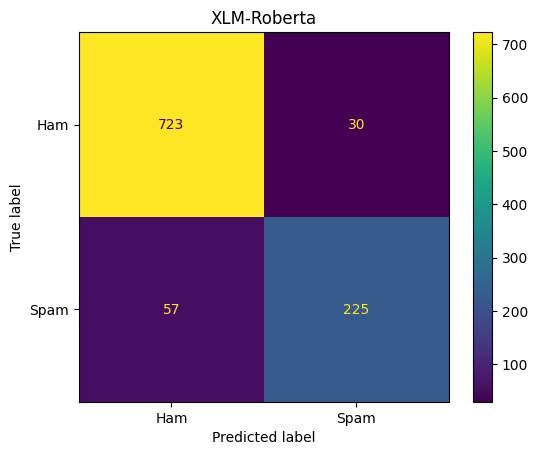

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
label_class = ['Ham', 'Spam']

y_test_single_label = np.argmax(y_test, axis=1)
preds_single_label_XLMRoberta_Dense = np.argmax(preds_XLMRoberta_Dense, axis=1)

cm = confusion_matrix(y_test_single_label, preds_single_label_XLMRoberta_Dense, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_class)
disp.plot()
plt.gca().grid(False)
plt.title('XLM-Roberta')

In [29]:
import torch

# Sau khi hoàn thành embedding
torch.cuda.empty_cache()

In [104]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập tạm (temporary set) và tập test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=2004)

# Chia tiếp tập tạm thành tập train và tập validation (validation nhỏ hơn test)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=2004)
# Lưu ý: test_size=0.15 ở đây nghĩa là 15% của tập tạm, tức là 80% * 15% = 12% của toàn bộ dữ liệu gốc.

# Kết quả:
print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 3515 samples
Validation set: 621 samples
Test set: 1035 samples


In [112]:
import numpy as np
# Tự động chuyển giá trị không hợp lệ thành NaN

# Chuyển cột cuối cùng thành kiểu số nguyên và mảng 1 chiều
label_idx_train = y_train.astype(int).to_numpy()

print(label_idx_train)

# Chuyển đổi nhãn thành định dạng one-hot encoding
label_tf_train = tf_keras.utils.to_categorical(label_idx_train, num_classes=2, dtype='float32')

[0 0 1 ... 1 0 0]


In [113]:
label_idx_test = y_test.astype(int).to_numpy()

print(label_idx_test)

# Chuyển đổi nhãn thành định dạng one-hot encoding
label_tf_test = tf_keras.utils.to_categorical(label_idx_test, num_classes=2, dtype='float32')

[0 0 0 ... 0 0 1]


In [114]:
# Chuyển cột cuối cùng thành kiểu số nguyên và mảng 1 chiều
label_idx_dev = y_val.astype(int).to_numpy()

print(label_idx_dev)

# Chuyển đổi nhãn thành định dạng one-hot encoding
label_tf_dev = tf_keras.utils.to_categorical(label_idx_dev, num_classes=2, dtype='float32')

[0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1
 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0
 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0
 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0
 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0
 1 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0
 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0
 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 1 0 1 

In [115]:
y_train = label_tf_train
y_val = label_tf_dev
y_test = label_tf_test

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (3515, 2)
y_val shape: (621, 2)
y_test shape: (1035, 2)


In [105]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 40048


In [31]:
!wget https://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip

--2024-12-20 14:32:08--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2024-12-20 14:32:08--  https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip]
Saving to: ‘glove.840B.300d.zip’

glove.840B.300d.zip 100%[===================>]   2.03G  5.04MB/s    in 6m 53s  

2024-12-20 14:39:01 (5.03 MB/s) - ‘glove.840B.300d.zip’ saved [2176768927/2176768927]

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [54]:
GLOVE_EMB = 'glove.840B.300d.txt'
EMBEDDING_DIM = 300
embeddings_index = {}

with open(GLOVE_EMB, 'r', encoding='utf8') as f:
    for line in f:
        values = line.rstrip().split(' ')
        word = ' '.join(values[:-EMBEDDING_DIM])
        coefs = np.asarray(values[-EMBEDDING_DIM:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))


Found 2196016 word vectors.


In [55]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [56]:
import tensorflow
embedding_layer = tensorflow.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          trainable=False)

In [57]:
GLOVE_EMB = 'glove.840B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-4
BATCH_SIZE = 768
EPOCHS = 30 
# MODEL_PATH = '/kaggle/working/text_classification_model.hdf5'

In [106]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 512


print(X_test)


1669    Subject: same day change - revision # 2 - txu ...
794     Subject: re : tenaska iv\ni ' ll call you on t...
1633    Subject: phillips petroleum\ni wanted to updat...
3509    Subject: epson inkjet cartridges from 5 . 99\n...
4172    Subject: re : meter 986315 for 10 / 00\nyou pu...
                              ...                        
4572    Subject: clickathome order verification\nthe c...
4978    Subject: fw : meter 98 - 7266 ; may 2001 texas...
1245    Subject: unify production back - eol deals hig...
2402    Subject: btu change\nplease note that i have r...
1830    Subject: approval # 5146\nhello ,\nwe sent you...
Name: text, Length: 1035, dtype: object


In [107]:
X_test.info()

<class 'pandas.core.series.Series'>
Index: 1035 entries, 1669 to 1830
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
1035 non-null   object
dtypes: object(1)
memory usage: 16.2+ KB


In [76]:
X_train.info()

<class 'pandas.core.series.Series'>
Index: 3516 entries, 1283 to Subject
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
3516 non-null   object
dtypes: object(1)
memory usage: 54.9+ KB


In [108]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = MAX_SEQUENCE_LENGTH)
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen = MAX_SEQUENCE_LENGTH)

# X_train_padded = pad_sequences(tokenizer.texts_to_sequences(df_trained.raw_text), maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
# X_test_padded = pad_sequences(tokenizer.texts_to_sequences(df_test.raw_text), maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (3515, 512)
Testing X Shape: (1035, 512)


In [124]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPool1D, Dropout, LayerNormalization
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Concatenate, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam

def generate_model(data_vocab_size):
    dropout_threshold = 0.3  # Reduced dropout
    input_dim = data_vocab_size
    output_dim = 128  # Increased embedding dimension
    input_length = 512
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, 
                        embeddings_initializer=initializer)(input_layer)

    # Convolutional Path
    cnn_feature = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(feature)  # Increased filters
    cnn_feature = MaxPool1D()(cnn_feature)  # Reduces to 256
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(cnn_feature)  # Increased filters
    cnn_feature = MaxPool1D()(cnn_feature)  # Reduces to 128
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    # Recurrent Path
    bi_lstm_feature = Bidirectional(LSTM(units=256, dropout=dropout_threshold, return_sequences=True,
                                         kernel_initializer=initializer))(cnn_feature)  # Increased units
    bi_lstm_feature = MaxPool1D()(bi_lstm_feature)  # Reduces to 64
    bi_lstm_feature = Bidirectional(GRU(units=256, dropout=dropout_threshold, return_sequences=True,
                                        kernel_initializer=initializer))(bi_lstm_feature)  # Increased units
    bi_lstm_feature = MaxPool1D()(bi_lstm_feature)  # Reduces to 32
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    # Apply GlobalMaxPooling1D to both feature maps
    cnn_pooled = GlobalMaxPooling1D()(cnn_feature)          # (None, 64)
    bi_lstm_pooled = GlobalMaxPooling1D()(bi_lstm_feature)  # (None, 128)

    # Concatenate the pooled features
    combine_feature = Concatenate()([cnn_pooled, bi_lstm_pooled])  # (None, 192)
    combine_feature = LayerNormalization()(combine_feature)

    # Classification Layers
    classifier = Dense(256, activation='relu')(combine_feature)  # Increased units
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(128, activation='relu')(combine_feature)  # Increased units
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(64, activation='relu')(classifier)  # Reduced units
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(2, activation='softmax')(classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=classifier)
    return model

# Example usage:
data_vocab_size = 40048  # Replace with your actual vocab size
model_LSTM = generate_model(data_vocab_size)
adam = Adam(learning_rate=0.0001)
model_LSTM.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_LSTM.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 512, 128)       │      5,126,144 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 512, 64)        │         24,640 │ embedding_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_20          │ (None, 256, 64)        │              0 │ conv1d_10[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 256, 64)        │              0 │ max_pooling1d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 256, 64)        │         12,352 │ dropout_30[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_21          │ (None, 128, 64)        │              0 │ conv1d_11[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_15    │ (None, 128, 64)        │            128 │ max_pooling1d_21[0][0] │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_31 (Dropout)      │ (None, 128, 64)        │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_10          │ (None, 128, 512)       │        657,408 │ dropout_31[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_22          │ (None, 64, 512)        │              0 │ bidirectional_10[0][0] │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_11          │ (None, 64, 512)        │      1,182,720 │ max_pooling1d_22[0][0] │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_23          │ (None, 32, 512)        │              0 │ bidirectional_11[0][0] │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_16    │ (None, 32, 512)        │          1,024 │ max_pooling1d_23[0][0] │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_10   │ (None, 64)             │              0 │ dropout_31[0][0]       │
│ (GlobalMaxPooling1D) 

 Total params: 7,087,810 (27.04 MB)

 Trainable params: 7,087,810 (27.04 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
print(y_val)

18      0
2963    0
1988    1
2416    0
732     0
       ..
2974    0
2697    0
3963    1
665     1
555     0
Name: label_num, Length: 621, dtype: int64


In [125]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_LSTM.fit(
    x=X_train,    
    y=y_train,           
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6549 - loss: 0.6713 - val_accuracy: 0.6747 - val_loss: 0.6084
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7191 - loss: 0.5751 - val_accuracy: 0.8969 - val_loss: 0.2265
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9483 - loss: 0.1368 - val_accuracy: 0.9694 - val_loss: 0.0905
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9906 - loss: 0.0268 - val_accuracy: 0.9646 - val_loss: 0.1217
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9960 - loss: 0.0127 - val_accuracy: 0.9807 - val_loss: 0.0826
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9980 - loss: 0.0066 - val_accuracy: 0.9791 - val_loss: 0.0785
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9966 - loss: 0.0077 - val_accuracy: 0.9758 - val_loss: 0.1104
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9985 - loss: 0.0039 - val_acc

In [ ]:
print(y_test)

In [126]:
model_LSTM.save('cnn_bi_lstm_sms_spam.keras')

In [149]:
from sklearn.metrics import classification_report
label_class = ['Ham', 'Spam']
model_LSTM.load_weights('/kaggle/working/cnn_bi_lstm_sms_spam.keras')
model_LSTM.evaluate(X_test, y_test)

preds_modelLSTM = model_LSTM.predict(X_test)
preds_modelLSTM = tf.round(preds_modelLSTM).numpy()

print(classification_report(y_test, preds_modelLSTM, target_names=label_class, zero_division=0))

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9811 - loss: 0.1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

         Ham       0.99      0.98      0.99       753
        Spam       0.95      0.97      0.96       282

   micro avg       0.98      0.98      0.98      1035
   macro avg       0.97      0.98      0.97      1035
weighted avg       0.98      0.98      0.98      1035
 samples avg       0.98      0.98      0.98      1035



Text(0.5, 1.0, 'CNN-BiLSTM')

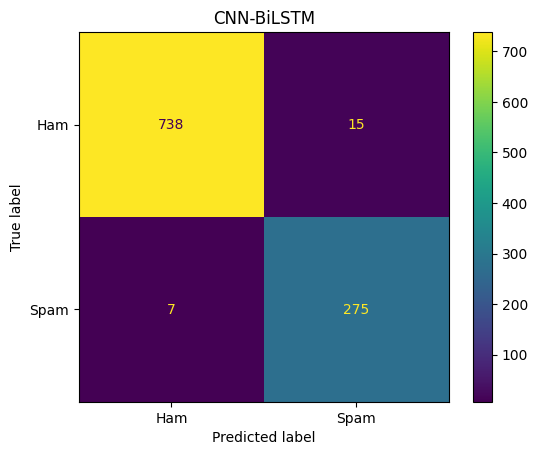

In [128]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
label_class = ['Ham', 'Spam']

y_test_single_label = np.argmax(y_test, axis=1)
preds_modelLSTM = np.argmax(preds_modelLSTM, axis=1)

cm = confusion_matrix(y_test_single_label, preds_modelLSTM, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_class)
disp.plot()
plt.gca().grid(False)
plt.title('CNN-BiLSTM')

In [150]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPool1D, Dropout, LayerNormalization
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Concatenate, GlobalMaxPooling1D, Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam

def generate_model_rnn(data_vocab_size):
    dropout_threshold = 0.3  # Reduced dropout
    input_dim = data_vocab_size
    output_dim = 128  # Increased embedding dimension
    input_length = 512
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, 
                        embeddings_initializer=initializer)(input_layer)

    # Convolutional Path
    cnn_feature = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(feature)  # Increased filters
    cnn_feature = MaxPool1D()(cnn_feature)  # Reduces to 256
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(cnn_feature)  # Increased filters
    cnn_feature = MaxPool1D()(cnn_feature)  # Reduces to 128
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    # Recurrent Path
    bi_lstm_feature = Bidirectional(SimpleRNN(units=256, dropout=dropout_threshold, return_sequences=True,
                                         kernel_initializer=initializer))(cnn_feature)  # Increased units
    bi_lstm_feature = MaxPool1D()(bi_lstm_feature)  # Reduces to 64
    bi_lstm_feature = Bidirectional(SimpleRNN(units=256, dropout=dropout_threshold, return_sequences=True,
                                        kernel_initializer=initializer))(bi_lstm_feature)  # Increased units
    bi_lstm_feature = MaxPool1D()(bi_lstm_feature)  # Reduces to 32
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    # Apply GlobalMaxPooling1D to both feature maps
    cnn_pooled = GlobalMaxPooling1D()(cnn_feature)          # (None, 64)
    bi_lstm_pooled = GlobalMaxPooling1D()(bi_lstm_feature)  # (None, 128)

    # Concatenate the pooled features
    combine_feature = Concatenate()([cnn_pooled, bi_lstm_pooled])  # (None, 192)
    combine_feature = LayerNormalization()(combine_feature)

    # Classification Layers
    classifier = Dense(256, activation='relu')(combine_feature)  # Increased units
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(128, activation='relu')(combine_feature)  # Increased units
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(64, activation='relu')(classifier)  # Reduced units
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(2, activation='softmax')(classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=classifier)
    return model

# Example usage:
model_RNN = generate_model_rnn(data_vocab_size)
adam1 = Adam(learning_rate=0.0001)
model_RNN.compile(optimizer=adam1, loss='categorical_crossentropy', metrics=['accuracy'])
model_RNN.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_17 (Embedding)  │ (None, 512, 128)       │      5,126,144 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_30 (Conv1D)        │ (None, 512, 64)        │         24,640 │ embedding_17[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_60          │ (None, 256, 64)        │              0 │ conv1d_30[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_80 (Dropout)      │ (None, 256, 64)        │              0 │ max_pooling1d_60[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_31 (Conv1D)        │ (None, 256, 64)        │         12,352 │ dropout_80[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_61          │ (None, 128, 64)        │              0 │ conv1d_31[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_45    │ (None, 128, 64)        │            128 │ max_pooling1d_61[0][0] │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_81 (Dropout)      │ (None, 128, 64)        │              0 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_30          │ (None, 128, 512)       │        164,352 │ dropout_81[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_62          │ (None, 64, 512)        │              0 │ bidirectional_30[0][0] │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_31          │ (None, 64, 512)        │        393,728 │ max_pooling1d_62[0][0] │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_63          │ (None, 32, 512)        │              0 │ bidirectional_31[0][0] │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_46    │ (None, 32, 512)        │          1,024 │ max_pooling1d_63[0][0] │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_30   │ (None, 64)             │              0 │ dropout_81[0][0]       │
│ (GlobalMaxPooling1D) 

 Total params: 5,805,762 (22.15 MB)

 Trainable params: 5,805,762 (22.15 MB)

 Non-trainable params: 0 (0.00 B)

In [161]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_RNN.fit(
    x=X_train,    
    y=y_train,           
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.6556 - loss: 0.6994 - val_accuracy: 0.6731 - val_loss: 0.6481
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6892 - loss: 0.6208 - val_accuracy: 0.6731 - val_loss: 0.6337
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7045 - loss: 0.6054 - val_accuracy: 0.6731 - val_loss: 0.6449
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7242 - loss: 0.5769 - val_accuracy: 0.6731 - val_loss: 0.7014
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8287 - loss: 0.3590 - val_accuracy: 0.9404 - val_loss: 0.1405
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9750 - loss: 0.0802 - val_accuracy: 0.9597 - val_loss: 0.1062
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9886 - loss: 0.0355 - val_accuracy: 0.9791 - val_loss: 0.0711
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9958 - loss: 0.0163 - val_accu

In [162]:
model_RNN.save('cnn_bi_rnn_sms_spam.h5', save_format='h5')

In [167]:
from sklearn.metrics import classification_report
label_class = ['Ham', 'Spam']
model_RNN.load_weights('/kaggle/working/cnn_bi_rnn_sms_spam.h5')
model_RNN.evaluate(X_test, y_test)

y_test_single_label = np.argmax(y_test, axis=1)
preds_modelRNN = model_RNN.predict(X_test)
preds_modelRNN = tf.round(preds_modelRNN).numpy()

print(classification_report(y_test, preds_modelRNN, target_names=label_class, zero_division=0))

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9686 - loss: 0.1513
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

         Ham       0.99      0.97      0.98       753
        Spam       0.94      0.98      0.95       282

   micro avg       0.97      0.97      0.97      1035
   macro avg       0.96      0.97      0.97      1035
weighted avg       0.98      0.97      0.98      1035
 samples avg       0.97      0.97      0.97      1035



Text(0.5, 1.0, 'CNN-BiRNN')

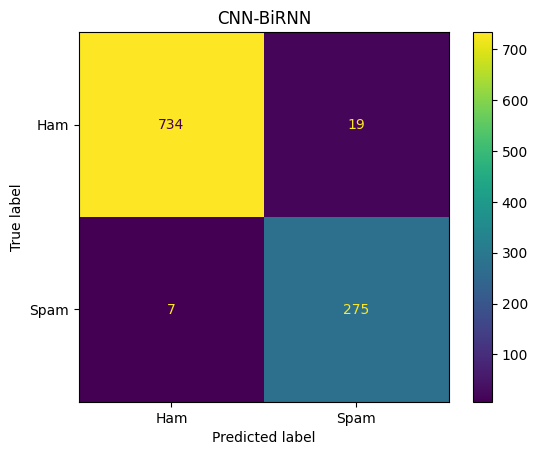

In [168]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
label_class = ['Ham', 'Spam']

y_test_single_label = np.argmax(y_test, axis=1)
preds_modelRNN = np.argmax(preds_modelRNN, axis=1)

cm = confusion_matrix(y_test_single_label, preds_modelRNN, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_class)
disp.plot()
plt.gca().grid(False)
plt.title('CNN-BiRNN')